In [37]:
import sys
import numpy as np
import time
import pickle

import random
import tensorflow as tf

import keras

from keras import backend as K
from keras.layers import Input, Embedding, GRU, Dense
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras import metrics, losses
from keras_tqdm import TQDMNotebookCallback

from subprocess import call
call(["jupyter", "nbextension", "enable", "--py", "--sys-prefix", "widgetsnbextension"])
%clear

In [3]:
def parse_file(tasks, fname):
    task = None
    for i, line in enumerate(open(fname)):
        id = int(line[0:line.find(' ')])
        if id == 1:
            task = {"C": "", "Q": "", "A": ""} 
            
        line = line.strip()
        line = line.replace('.', ' . ')
        line = line[line.find(' ')+1:]
        if line.find('?') == -1:
            task["C"] += line
        else:
            idx = line.find('?')
            tmp = line[idx+1:].split('\t')
            task["Q"] = line[:idx]
            task["A"] = tmp[1].strip()
            tasks.append(task.copy())
    return tasks

In [4]:
train_set = []
test_set = []
for i in range(1, 21):
    train_set_text = parse_file(train_set, "tasks_1-20_v1-2/en-valid-10k/qa" + str(i) + "_train.txt")
    test_set_text = parse_file(test_set, "tasks_1-20_v1-2/en-valid-10k/qa" + str(i) + "_test.txt")

In [5]:
def glove_to_voc(fname):
    voc = {}
    with open(fname) as f:
        for line in f:    
            l = line.split()
            voc[l[0]] = list(map(float, l[1:]))
    return voc

In [6]:
word_vector_size = 50
vocabulary = {}
vocabulary["PAD"] = 0
inv_vocabulary = {}
inv_vocabulary[0] = "PAD"

In [7]:
glove = glove_to_voc("glove.6B.50d.txt")

In [8]:
def get_word_vector(word, glove, vocabulary, inv_vocabulary):
    if not word in vocabulary: 
        next_index = len(vocabulary)
        vocabulary[word] = next_index
        inv_vocabulary[next_index] = word
    
    return vocabulary[word]

In [9]:
def process_input(text):
        questions = []
        inputs = []
        answers = []
        input_masks = []
        for x in text:
            inp = [w for w in x["C"].lower().split(' ')  if len(w) > 0]
            q = [w for w in x["Q"].lower().split(' ') if len(w) > 0]
            answ = [w for w in x["A"].lower().split(',') if len(w) > 0]
            
            inp_vector = [get_word_vector(word = w, 
                                        glove = glove, 
                                        vocabulary = vocabulary, 
                                        inv_vocabulary = inv_vocabulary) for w in inp]
              
            inputs.append(np.vstack(inp_vector))
            
            q_vector = [get_word_vector(word = w,
                                        glove = glove, 
                                        vocabulary = vocabulary, 
                                        inv_vocabulary = inv_vocabulary) for w in q]
            
            questions.append(np.vstack(q_vector))
            

            ans_vector = [get_word_vector(word = w,
                                            glove = glove, 
                                            vocabulary = vocabulary, 
                                            inv_vocabulary = inv_vocabulary) for w in answ]

            while(len(ans_vector) < 3):
                ans_vector.append(0)
            answers.append(np.vstack(ans_vector))
            
            input_masks.append(np.array([index for index, w in enumerate(inp) if w == '.'], dtype=np.int32)) 
        return inputs, questions, answers, input_masks

In [10]:
max_c_len = 300
max_q_len = 7
hidden_size = 84
max_ans_len = 3

In [11]:
context, questions, answers, masks = process_input(train_set_text)
val_context, val_questions, val_answers, val_masks = process_input(test_set_text)

In [12]:
def make_mat(answers, len1, len2):
    mt = np.zeros((len(answers), len1, len2))
    for i in range(len(answers)):
        for j in range(len1):
            mt[i][j][answers[i][j]] = 1
    return mt

In [13]:
pcontext = pad_sequences(context, maxlen=max_c_len, dtype='int32', padding='post', truncating='post', value=0)
pcontext = pcontext.reshape(pcontext.shape[:2])
pquestions = pad_sequences(questions, maxlen=max_q_len, dtype='int32', padding='post', truncating='post', value=0)
pquestions = pquestions.reshape(pquestions.shape[:2])
ans_mat = make_mat(answers, max_ans_len, len(vocabulary))

In [14]:
val_pquestions = pad_sequences(val_questions, maxlen=max_q_len, dtype='int32', padding='post', truncating='post', value=0)
val_pquestions = val_pquestions.reshape(val_pquestions.shape[:2])
val_pcontext = pad_sequences(val_context, maxlen=max_c_len, dtype='int32', padding='post', truncating='post', value=0)
val_pcontext = val_pcontext.reshape(val_pcontext.shape[:2])
val_ans_mat = make_mat(val_answers, 3, len(vocabulary))

In [15]:
embedding_matrix = np.zeros((len(vocabulary), 50))
for word in vocabulary.keys():
    if not word in glove:
        glove[word] = np.random.uniform(0.0,1.0,(word_vector_size,))
    embedding_matrix[vocabulary[word]] = glove[word]

In [16]:
from gru_inh import myGru

In [ ]:
def custom_categorical_accuracy(y_true, y_pred):
    return K.min(K.cast(K.equal(K.argmax(y_true, axis=-1),
                          K.argmax(y_pred, axis=-1)),
                  K.floatx()), axis=-1)

In [17]:
#input module

context_input = Input(shape=(max_c_len,), dtype='int32', name='context_input')

embedded_context = Embedding(input_dim = len(vocabulary),
                            output_dim = 50,
                            weights=[embedding_matrix],
                            input_length=max_c_len,
                            mask_zero = True,
                            trainable=False) (context_input)

facts = GRU(units=hidden_size, return_sequences=True) (embedded_context)

# question module

question_input = Input(shape=(max_q_len,), dtype='int32', name='question_input')

embedded_question= Embedding(input_dim = len(vocabulary),
                            output_dim = 50,
                            weights=[embedding_matrix],
                            input_length=max_q_len,
                            mask_zero = True,
                            trainable=False) (question_input)

question_rep = GRU(units=hidden_size) (embedded_question)

many_quests = keras.layers.core.RepeatVector(max_c_len) (question_rep)

# episodic memory module

concated = keras.layers.concatenate([facts, many_quests])
memory = myGru(units=hidden_size, implementation = 1) (concated)

# answer module

three_memories = keras.layers.RepeatVector(3) (memory)
to_answer = GRU(units=hidden_size, return_sequences=True) (three_memories)
net_output = keras.layers.TimeDistributed(Dense(units=len(vocabulary), activation="softmax")) (to_answer)

In [18]:
model = Model(inputs=[context_input, question_input], outputs=[net_output])

In [31]:
model.compile(optimizer='rmsprop',
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy,
                      custom_categorical_accuracy])

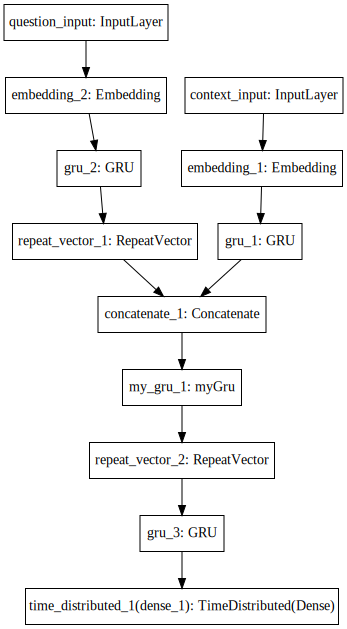

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [97]:
model.fit([pcontext, pquestions], ans_mat,epochs=2, verbose=0, 
          callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
          validation_data=([val_pcontext, val_pquestions], val_ans_mat))

          179968/|/[loss: 0.113, categorical_accuracy: 0.943, custom_categorical_accuracy: 0.857] 100%|| 179968/179998 [2:48:10<00:01, 18.06it/s]179968/|/[loss: 0.107, categorical_accuracy: 0.946, custom_categorical_accuracy: 0.868] 100%|| 179968/179998 [2:50:12<00:01, 17.94it/s]

In [35]:
model.save("weights.h5")

In [38]:
with open('vocabulary.pkl', 'wb') as f:
        pickle.dump(vocabulary, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
model = load_model("weights.h5")

In [93]:
new_voc = {}
with open('vocabulary.pkl', 'rb') as f:
        new_voc = pickle.load(f)
new_inv_voc = {v: k for k, v in new_voc.items()}

In [91]:
def get_answer(model, vocabulary, inv_vocabulary, context, question):
    context = context.replace('.', ' . ')
    inp = [w for w in context.lower().split(' ')  if len(w) > 0]
    if '?' in question:
        question = question[:question.find('?')]
    q = [w for w in question.lower().split(' ') if len(w) > 0]
    inp_vector = [vocabulary[w] for w in inp]
    quest_vector = [vocabulary[w] for w in q]
    cur_context = pad_sequences([inp_vector], maxlen=max_c_len, dtype='int32',
                      padding='post', truncating='post', value=0)
    cur_question = pad_sequences([quest_vector], maxlen=max_q_len, dtype='int32',
                      padding='post', truncating='post', value=0)
    prediction = model.predict([cur_context, cur_question])
    answer = []
    for i in range(max_ans_len):
        cur_word = np.argmax(prediction[0][i])
        if cur_word == 0:
            break
        answer.append(inv_vocabulary[cur_word])
    return ', '.join(answer)

In [94]:
print(get_answer(model, new_voc, new_inv_voc, 'John travelled to the garden. John journeyed to the kitchen.', 'Where is John?'))

kitchen
